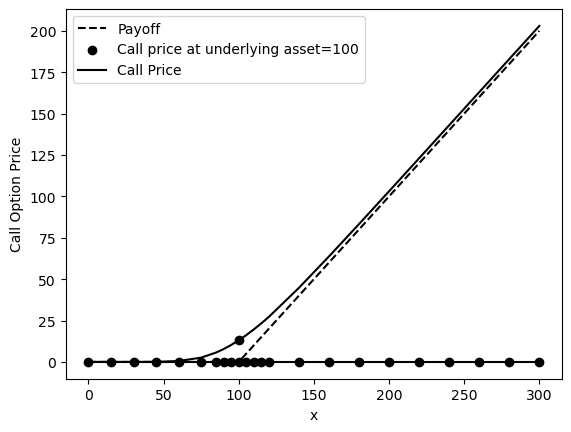

Price=13.069568


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def thomas(alpha, beta, gamma, f):
    """
    Solves a tridiagonal system using the Thomas algorithm.
    
    Parameters:
    alpha: Lower diagonal elements (length n)
    beta : Main diagonal elements (length n)
    gamma: Upper diagonal elements (length n)
    f    : Right-hand side vector (length n)
    
    Returns:
    v    : Solution vector (length n)
    """
    n = len(f)
    v = np.zeros(n, dtype=float)
    
    # Copy input arrays to avoid modifying originals
    alpha = np.array(alpha, dtype=float)
    beta = np.array(beta, dtype=float)
    gamma = np.array(gamma, dtype=float)
    f = np.array(f, dtype=float)

    # Forward Elimination phase
    for i in range(1, n):
        mult = alpha[i] / beta[i - 1]
        beta[i] = beta[i] - mult * gamma[i - 1]
        f[i] = f[i] - mult * f[i - 1]

    # Back Substitution phase
    v[n - 1] = f[n - 1] / beta[n - 1]
    for i in range(n - 2, -1, -1):
        v[i] = (f[i] - gamma[i] * v[i + 1]) / beta[i]

    return v

# Define parameters
K = 100              # Strike price
volatility = 0.3     # Volatility of the underlying asset
r = 0.03             # Risk-free interest rate
T = 1                # Time to maturity (in years)
Nt = 360             # Number of time steps
dt = T / Nt          # Time step size

# Define spatial grid (non-uniform)
A = np.arange(0, 80, 15)      # Low range: 0 to 75 with step 15
B = np.arange(85, 125, 5)     # Mid range: 85 to 120 with step 5
C = np.arange(140, 320, 20)   # High range: 140 to 300 with step 20
x = np.r_[A, B, C]            # Concatenate all ranges into one grid
h = np.diff(x)                # Compute spatial step sizes
h = np.r_[h[0], h, h[-1]]     # Extend step sizes for boundary conditions
Nx = len(x)                   # Number of spatial grid points

# Initialize solution array: rows = spatial points, columns = time steps
u = np.zeros([Nx, Nt + 1])
u[:, 0] = np.maximum(x - K, 0)  # Initial condition: payoff at maturity

# Plot the initial payoff
plt.plot(x, u[:, 0], 'k--', label='Payoff')

# Initialize tridiagonal matrix coefficients
[a, d, c, b] = map(np.zeros, [Nx-1, Nx-1, Nx-1, Nx-1])

# Set up coefficients for the implicit finite difference scheme
a[:] = (-volatility**2 * x[1:Nx]**2 + r * x[1:Nx] * h[2:Nx+1]) / (h[1:Nx] * (h[1:Nx] + h[2:Nx+1]))
d[:] = (volatility**2 * x[1:Nx]**2 - r * x[1:Nx] * (h[2:Nx+1] - h[1:Nx])) / (h[1:Nx] * h[2:Nx+1]) + r + 1/dt
c[:] = (-volatility**2 * x[1:Nx]**2 - r * x[1:Nx] * h[1:Nx]) / (h[2:Nx+1] * (h[1:Nx] + h[2:Nx+1]))

# Apply boundary condition adjustments
a[Nx-2] = a[Nx-2] - c[Nx-2]
d[Nx-2] = d[Nx-2] + 2 * c[Nx-2]

# Time-stepping loop
for n in range(0, Nt):
    b = u[1:Nx, n] / dt          # Right-hand side for current time step
    u[1:Nx, n+1] = thomas(a, d, c, b)  # Solve using Thomas algorithm

# Find index where underlying asset price is 100
ii = np.where(x == 100)

# Plot results
plt.scatter(x[ii], u[ii, Nt], color='k', label='Call price at underlying asset=100')
plt.plot(x, u[:, Nt], 'k-', label='Call Price')  # Final option price
plt.plot(x, 0 * u[:, Nt], 'ko-')                # Zero line for reference
plt.xlabel('x', fontsize=10)                    # X-axis label
plt.ylabel('Call Option Price', fontsize=10)    # Y-axis label
plt.legend(loc='upper left')                    # Add legend
plt.show()

# Print the option price at x = 100
print('Price=%f' % u[ii, Nt].item())

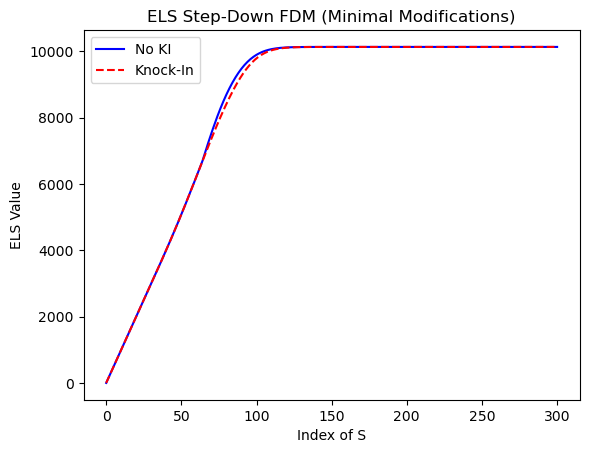

ELS Price : 9898.3472


In [2]:
# The following code implements the ELS pricing using a finite difference method (FDM).
# It uses the Thomas algorithm for solving tridiagonal systems.
# The original code logic is preserved with minimal modifications in variable names and typos.

import numpy as np
import matplotlib.pyplot as plt

#############################
# (1) Thomas Algorithm
#############################
def thomas(lower_diag, main_diag, upper_diag, rhs):
    """
    Simple tridiagonal matrix solver using the Thomas algorithm.
    
    Parameters:
      lower_diag: Lower diagonal (length n)
      main_diag : Main diagonal (length n)
      upper_diag: Upper diagonal (length n)
      rhs       : Right-hand side vector (length n)
    
    Returns:
      The solution vector v.
    """
    n = len(rhs)
    v = np.zeros(n, dtype=float)
    
    # Create copies to avoid modifying the original inputs.
    a = lower_diag.copy()
    b = main_diag.copy()
    c = upper_diag.copy()
    rhs_copy = rhs.copy()

    # Forward elimination
    for i in range(1, n):
        mult = a[i] / b[i - 1]
        b[i] = b[i] - mult * c[i - 1]
        rhs_copy[i] = rhs_copy[i] - mult * rhs_copy[i - 1]

    # Back substitution
    v[n - 1] = rhs_copy[n - 1] / b[n - 1]
    for i in range(n - 2, -1, -1):
        v[i] = (rhs_copy[i] - c[i] * v[i + 1]) / b[i]

    return v

#############################
# (2) Parameter Settings
#############################
FACE_VALUE    = 10000        # Face value of the ELS
R             = 300          # Maximum asset value domain
volatility    = 0.1778
risk_free_rate = 0.0165

Nx = 301                    # Number of grid points for the asset price
h  = R / Nx                # Space step (dividing R by Nx)
x0 = 100                   # Reference asset price (initial asset price)
x  = np.linspace(0, R, Nx)  # Asset price grid

T  = 3                     # Maturity (years)
Nt = int(360 * T)          # Number of time steps
dt = T / Nt               # Time step

#############################
# (3) Array Preparation
#############################
# price_no_KI: ELS values when Knock-In does NOT occur
# price_KI   : ELS values when Knock-In occurs
price_no_KI = np.zeros((Nx, Nt + 1))
price_KI    = np.zeros((Nx, Nt + 1))

coupon_rate  = np.array([0.132, 0.11, 0.088, 0.066, 0.044, 0.022])
strike_price = np.array([0.85, 0.90, 0.90, 0.95, 0.95, 0.95])

# Time steps corresponding to early redemption events.
steps = np.array([
    np.rint(Nt / 6),
    np.rint(2 * Nt / 6),
    np.rint(3 * Nt / 6),
    np.rint(4 * Nt / 6),
    np.rint(5 * Nt / 6),
    Nt + 1   # As in the original user code
], dtype=int)

dummy_coupon = 0.132  # Coupon rate for intermediate condition (dummy)
kib          = 0.65    # Knock-In Barrier level as a fraction of x0

#############################
# (4) Initial Conditions
#############################
for i in range(Nx):
    if x[i] <= kib * x0:
        price_no_KI[i, 0] = (x[i] / x0) * FACE_VALUE
        price_KI[i, 0]    = (x[i] / x0) * FACE_VALUE
    elif x[i] < strike_price[0] * x0:
        price_no_KI[i, 0] = FACE_VALUE * (1 + dummy_coupon)
        price_KI[i, 0]    = (x[i] / x0) * FACE_VALUE
    else:
        price_no_KI[i, 0] = FACE_VALUE * (1 + coupon_rate[0])
        price_KI[i, 0]    = FACE_VALUE * (1 + coupon_rate[0])

#############################
# (5) PDE Coefficients: a, d, c, b
#############################
# Create coefficient arrays with zeros.
# Here, a, d, c correspond to the lower, main, and upper coefficients, respectively.
[lower_coef, main_coef, upper_coef, _] = map(np.zeros, [Nx, Nx, Nx, Nx])

# Coefficient assignments as in the original user code.
lower_coef[:] = risk_free_rate * x / (2 * h) - (volatility * x) ** 2 / (2 * h ** 2)
main_coef[:]  = (volatility * x) ** 2 / (h ** 2) + risk_free_rate + (1.0 / dt)
upper_coef[:] = -risk_free_rate * x / (2 * h) - (volatility * x) ** 2 / (2 * h ** 2)

# Adjust coefficients at the lower boundary (at index Nx-1) as in the original code.
lower_coef[Nx - 1] = lower_coef[Nx - 1] - upper_coef[Nx - 1]
main_coef[Nx - 1] = main_coef[Nx - 1] + 2 * upper_coef[Nx - 1]

#############################
# (6) Time Loop
#############################
event_tag = 0
for n in range(Nt):
    # (a) Early Redemption Evaluation
    if n == steps[event_tag]:
        if event_tag < len(coupon_rate):
            # Reference strike_price[event_tag+1] and coupon_rate[event_tag+1] (possibility of index overflow is kept as in original)
            s_index = np.min(np.where(x >= x0 * strike_price[event_tag + 1]))
            # For the "no Knock-In" case:
            price_no_KI[s_index:Nx + 1, n] = FACE_VALUE * (1 + coupon_rate[event_tag + 1])
            # For the "Knock-In" case:
            price_KI[s_index:Nx + 1, n] = FACE_VALUE * (1 + coupon_rate[event_tag + 1])
        event_tag += 1

    # (b) Check Knock-In Barrier:
    barrier_index = np.min(np.where(x >= x0 * kib))
    price_no_KI[0:barrier_index, n] = price_KI[0:barrier_index, n]

    # (c) Finite Difference (FDM) step using the Thomas algorithm.
    rhs_no_KI = price_no_KI[:, n] / dt
    rhs_KI    = price_KI[:, n] / dt

    price_no_KI[:, n + 1] = thomas(lower_coef, main_coef, upper_coef, rhs_no_KI)
    price_KI[:, n + 1]    = thomas(lower_coef, main_coef, upper_coef, rhs_KI)

#############################
# (7) Output Results
#############################
plt.figure()
plt.plot(price_no_KI[:, Nt], 'b-', label='No KI')
plt.plot(price_KI[:, Nt], 'r--', label='Knock-In')
plt.xlabel("Index of S")
plt.ylabel("ELS Value")
plt.title("ELS Step-Down FDM (Minimal Modifications)")
plt.legend()
plt.show()

idx_100 = np.where(np.isclose(x, 100))[0]
if len(idx_100) > 0:
    print("ELS Price : %.4f" % price_no_KI[idx_100[0], Nt])